# Dimensional Analysis

**Reading: 7.1, 7.4.1, 7.5-7.8, 7.9.2, 7.10**

  
Working with students in my research lab, I have found that some of the **most neglected** or misunderstood principles are those related to dimensional analysis and dynamic similarity.  We will talk more about what dynamic similarity is in class, but to get started let's look at a few motivating examples.  Understanding the code is not critical to understanding the concepts, but it would be useful to understand and explore on your on.

## Wind Turbine Example

We are going to look at an example of a simulation (or experiment) predicting the power output of a wind turbine as a function of the wind speed and the rotation speed of the rotor.  

First, we need to do some setup.  You can completely ignore this next code block&mdash;its details are not important to our discussion.  It just imports some modules, sets a plot style, and defines a very simple power calculation function.  It's basically a look-up table with numbers that come from pre-running my full turbine analysis code (https://github.com/wisdem/ccblade).  The important point is that you now have a  method ``power`` that computes the wind turbine's power output for a  specified wind speed $U_\infty$ and turbine rotation speed $\Omega$ (for some pre-selected geometry).  In addition, I've added a little random Gaussian noise in case you want to think of the outputs as experimental data.  

In [3]:
%matplotlib inline

import numpy as np
from math import pi
import matplotlib.pyplot as plt

# setup plot style
plt.style.use('ggplot')
plt.rcParams['font.size'] = 18.0
plt.rcParams['figure.figsize'] = '7.0, 5.2'
plt.rcParams['lines.markersize'] = 8.0

def power(Uinf, Omega):
    Rtip = 63.0
    rho = 1.225
    tsr = Omega*pi/30.0*Rtip/Uinf
    
    tsrV = np.linspace(1, 18, 50)
    CPV = np.array([0.0051582969252168265, 0.0078368606973244839, 0.013165552495878379, 0.025127527586220052, 0.045944561271158105, 0.074525830251031017, 0.10855095748435095, 0.14580969059900983, 0.18492236877346321, 0.22601552590539764, 0.26994898861654087, 0.31656353230581302, 0.36160006778421366, 0.39860111624800532, 0.424349912982949, 0.44115672062700917, 0.45219160365421102, 0.45926496268053218, 0.46334909648965472, 0.46495676519844836, 0.46440618292238589, 0.46195433684911774, 0.45782637190152536, 0.45227437793771447, 0.44556705415118902, 0.43794643800210098, 0.42955698106676804, 0.42041151934919924, 0.41047515135334811, 0.39971776136796933, 0.3881151227580602, 0.37563728366652888, 0.36224867466992822, 0.34791525639561632, 0.33260462373502292, 0.31628695819045533, 0.29893738026716216, 0.28054069643667945, 0.26110471808240104, 0.24066522063541104, 0.21923002382015289, 0.19680854209630785, 0.17348393269700382, 0.14935107809913706, 0.1244265247555085, 0.098695924717879385, 0.072144631367803844, 0.044771616959821792, 0.016680229959477631, 0.0])
    CP = np.interp(tsr, tsrV, CPV)
    P = CP * (0.5*rho*Uinf**3 * pi*Rtip**2)
    
    error = np.random.randn(len(P))* 0.03*P
    P += error

    return P

Let's run this funciton for a bunch of different wind speeds and turbine rotation speeds (you could think of running these cases experimentally).  To begin with, we will just choose these operational points randomly from uniform probability distributions
$$ U_\infty \in [5.0, 15.0] \text{ m/s}$$
$$ \Omega \in [1.0, 30.0] \text{ rpm}$$

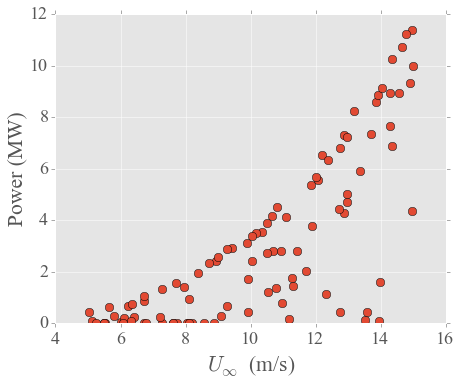

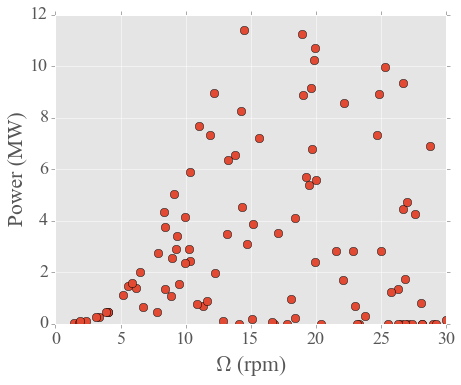

In [2]:
# number of pts to evaluate
n = 100

# random inputs
Uinf = 5.0 + (15.0-5.0)*np.random.rand(n)  # m/s
Omega = 1.0 + (30.0-1.0)*np.random.rand(n)  # rpm

# evaluate power
P = power(Uinf, Omega)

# generate some plots
plt.figure()
plt.plot(Uinf, P/1e6, 'o')
plt.xlabel('$U_\infty$ (m/s)')
plt.ylabel('Power (MW)')

plt.figure()
plt.plot(Omega, P/1e6, 'o')
plt.xlabel('$\Omega$ (rpm)')
plt.ylabel('Power (MW)');

There appears to be very little structure in this data.  In other words, if I gave you a wind speed, you'd wouldn't be able to predict the power output (although it appears as if we could define a maximum power, which is true).  The same conclusion applies for the rotation speed.  From 7.1 you learned that appropriately chosen nondimensional parameters can simplify the relationships between variables.  The important parameters in this case are the tip-speed ratio
$$\lambda = \frac{\Omega R}{U_\infty}$$
and the power coefficient
$$ C_P = \frac{P}{\frac{1}{2} \rho U_\infty^3 (\pi R^2)}$$
Instead of our current function
$$ P = f(U_\infty, \Omega)$$
we expect that by nondimensionalizing we can achieve a simplifed functional form of
$$ C_P = f(\lambda)$$

Let's take our same data, normalize it approprirately, then replot.

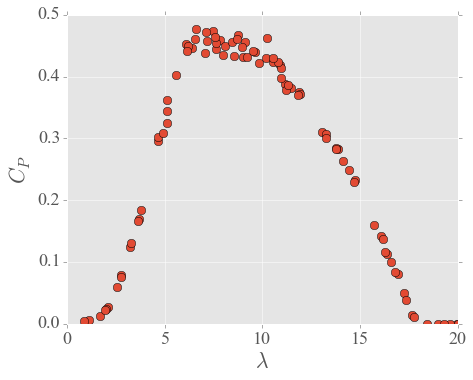

In [5]:
# normalize  (this comes from our known geometry and operational point)
Rtip = 63.0
rho = 1.225

tsr = Omega*pi/30.0*Rtip/Uinf  # with conversion from RPM to Hz
CP = P / (0.5*rho*Uinf**3 * pi*Rtip**2)

plt.figure()
plt.plot(tsr, CP, 'o')
plt.xlim([0.0, 20.0])
plt.xlabel('$\lambda$')
plt.ylabel('$C_P$');

Now, the structure in the data is clearly visible.  If I gave you a freestream velocity, and a rotation rate, you could predict the power coefficient without running any additional experiments.  Additionally, if you were trying to build a predictive computational model, you could now do so easily.

Of course, most people don't run purely random input points.  A scenario that I see more frequently looks like the one below.  In this case we are going to ramp up the wind speed from 5 to 15 m/s (e.g., in a wind tunnel), and we are going to repeat that for 4 discrete fixed rotation speeds ($\Omega = 3, 10, 20, 30$ rpm).  The variation in power for all four rotation speeds is shown in the plot below.

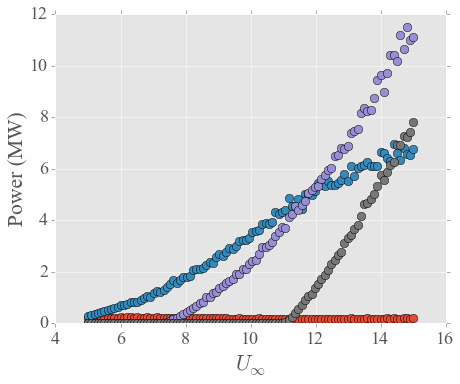

In [7]:
# sets of rotation speeds
Omegavec = [3.0, 10.0, 20.0, 30.0]
nspeeds = len(Omegavec)
Uinf = np.linspace(5.0, 15.0, n)  # m/s

# evaluate power curve for each rotation speed
P = np.zeros((nspeeds, n))
for i in range(nspeeds):
    P[i, :] = power(Uinf, Omegavec[i]*np.ones(n))

plt.figure()
for i in range(nspeeds):
    plt.plot(Uinf, P[i, :]/1e6, 'o')
plt.xlabel('$U_\infty$')
plt.ylabel('Power (MW)');

There is clearly some well-defined relationships.  Although, it appears that there is a separate relationship for each rotation speed.  Let's normalize the data, in the same manner we did previously, and replot.

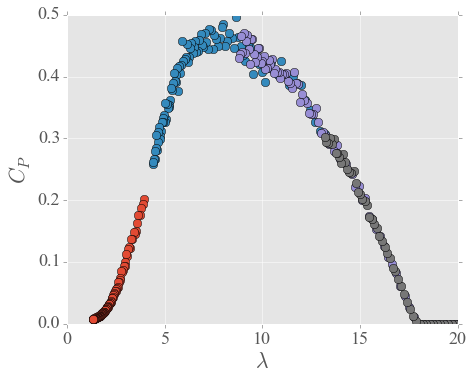

In [8]:
# normalize
tsr = np.zeros((nspeeds, n))
for i in range(nspeeds):
    tsr[i, :] = Omegavec[i]*pi/30.0*Rtip/Uinf

CP = P / (0.5*rho*Uinf**3 * pi*Rtip**2)

plt.figure()
for i in range(nspeeds):
    plt.plot(tsr[i, :], CP[i, :], 'o')
plt.xlim([0.0, 20.0])
plt.xlabel('$\lambda$')
plt.ylabel('$C_P$');

Again, it is apparent that we weren't really generating separate data relationships, but rather evaluating different portions of one underlying data relationship.  This simple example highlights the importance, and the power of proper nondimensional analysis.